### 임상도 데이터 EDA

In [1]:
import geopandas as gpd

In [ ]:
# 강원특별자치도 임상도 파일 불러오기
gdf = gpd.read_file("../data/raw/임상도/강원특별자치도/51_1.shp")

In [5]:
gdf.crs

<Projected CRS: ESRI:102080>
Name: KGD2002_Unified_Coordinate_System
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
#좌표계 확인 및 변환 (EPSG:5179은 UTM-K 기준), GeoPandas에서의 분석을 위해 변환
if gdf.crs != "epsg:5179":
    gdf = gdf.to_crs(epsg=5179)
    print("Coordinate Reference System Converted")

Coordinate Reference System Converted


In [7]:
gdf.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
gdf.head(3)

,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,DNST_CD,HEIGHT,LDMARK_STN,MAP_LABEL,...,ETC_PCMTT,FRTP_NM,KOFTR_NM,DMCLS_NM,AGCLS_NM,DNST_NM,HEIGHT_NM,Shape_Leng,Shape_Area,geometry
0,1,2,1,11,2,4,C,18,J12111,NPD-24C,...,None,침엽수림,소나무,중경목,4영급,밀,임분고 17m 이상 19m미만,897.660368,20291.015161,"POLYGON ((1106819.887 1984940.023, 1106820.555..."
1,0,0,0,93,None,None,None,None,J00093,C,...,2017영상판독,무립목지/비산림,경작지,None,None,None,None,365.363919,3568.443965,"POLYGON ((1116942.408 1973566.56, 1116939.047 ..."
2,1,1,1,11,1,3,C,10,J11111,APD-13C,...,None,침엽수림,소나무,소경목,3영급,밀,임분고 9m 이상 11m미만,192.265075,1359.940128,"POLYGON ((1115611.682 1974353.956, 1115616.04 ..."


In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 282113 entries, 0 to 282112
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   STORUNST    282113 non-null  object  
 1   FROR_CD     282113 non-null  object  
 2   FRTP_CD     282113 non-null  object  
 3   KOFTR_GROU  282113 non-null  object  
 4   DMCLS_CD    262378 non-null  object  
 5   AGCLS_CD    262378 non-null  object  
 6   DNST_CD     262378 non-null  object  
 7   HEIGHT      262228 non-null  object  
 8   LDMARK_STN  282113 non-null  object  
 9   MAP_LABEL   282113 non-null  object  
 10  갱신년도        189314 non-null  object  
 11  ETC_PCMTT   19261 non-null   object  
 12  FRTP_NM     282113 non-null  object  
 13  KOFTR_NM    282113 non-null  object  
 14  DMCLS_NM    262378 non-null  object  
 15  AGCLS_NM    262378 non-null  object  
 16  DNST_NM     262378 non-null  object  
 17  HEIGHT_NM   262228 non-null  object  
 18  Shape_Leng  2821

In [10]:
gdf.shape

(282113, 21)

<Axes: >

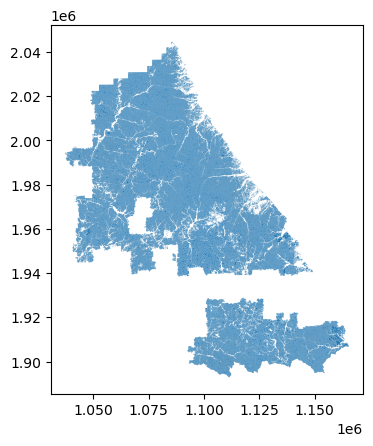

In [ ]:
gdf.plot()

### 대한민국 행정지역 데이터 EDA

In [19]:
sid = gpd.read_file("../data/raw/대한민국행정구역/시도/ctprvn.shp", encoding="euc-kr")
sig = gpd.read_file("../data/raw/대한민국행정구역/시군구/sig.shp", encoding="euc-kr")
emd = gpd.read_file("../data/raw/대한민국행정구역/읍면동/emd.shp", encoding="euc-kr")
li = gpd.read_file("../data/raw/대한민국행정구역/리/li.shp", encoding="euc-kr")

In [20]:
from IPython.display import display

display(sid.head())
display(sig.head())
display(emd.head())
display(li.head())

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,서울특별시,"POLYGON ((966987.226 1941110.946, 966987.119 1..."
1,26,Busan,부산광역시,"MULTIPOLYGON (((1148194.981 1685460.055, 11481..."
2,27,Daegu,대구광역시,"POLYGON ((1087859.999 1760097.461, 1087859.951..."
3,28,Incheon,인천광역시,"MULTIPOLYGON (((847834.755 1881816.658, 847840..."
4,29,Gwangju,광주광역시,"POLYGON ((932712.687 1696168.692, 932781.68 16..."


,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.25, 964875.565 19..."


,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.19 19..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."


,LI_CD,LI_ENG_NM,LI_KOR_NM,geometry
0,2671025021,Dongbu-ri,동부리,"POLYGON ((1156572.843 1696804.747, 1156605.133..."
1,2671025022,Gyo-ri,교리,"POLYGON ((1155731.257 1697372.017, 1155813.409..."
2,2671025023,Sincheon-ri,신천리,"POLYGON ((1157572.293 1695843.731, 1157584.155..."
3,2671025024,Jukseong-ri,죽성리,"POLYGON ((1158010.875 1696998.51, 1158017.903 ..."
4,2671025025,Seobu-ri,서부리,"POLYGON ((1155615.822 1696551.022, 1155624.394..."


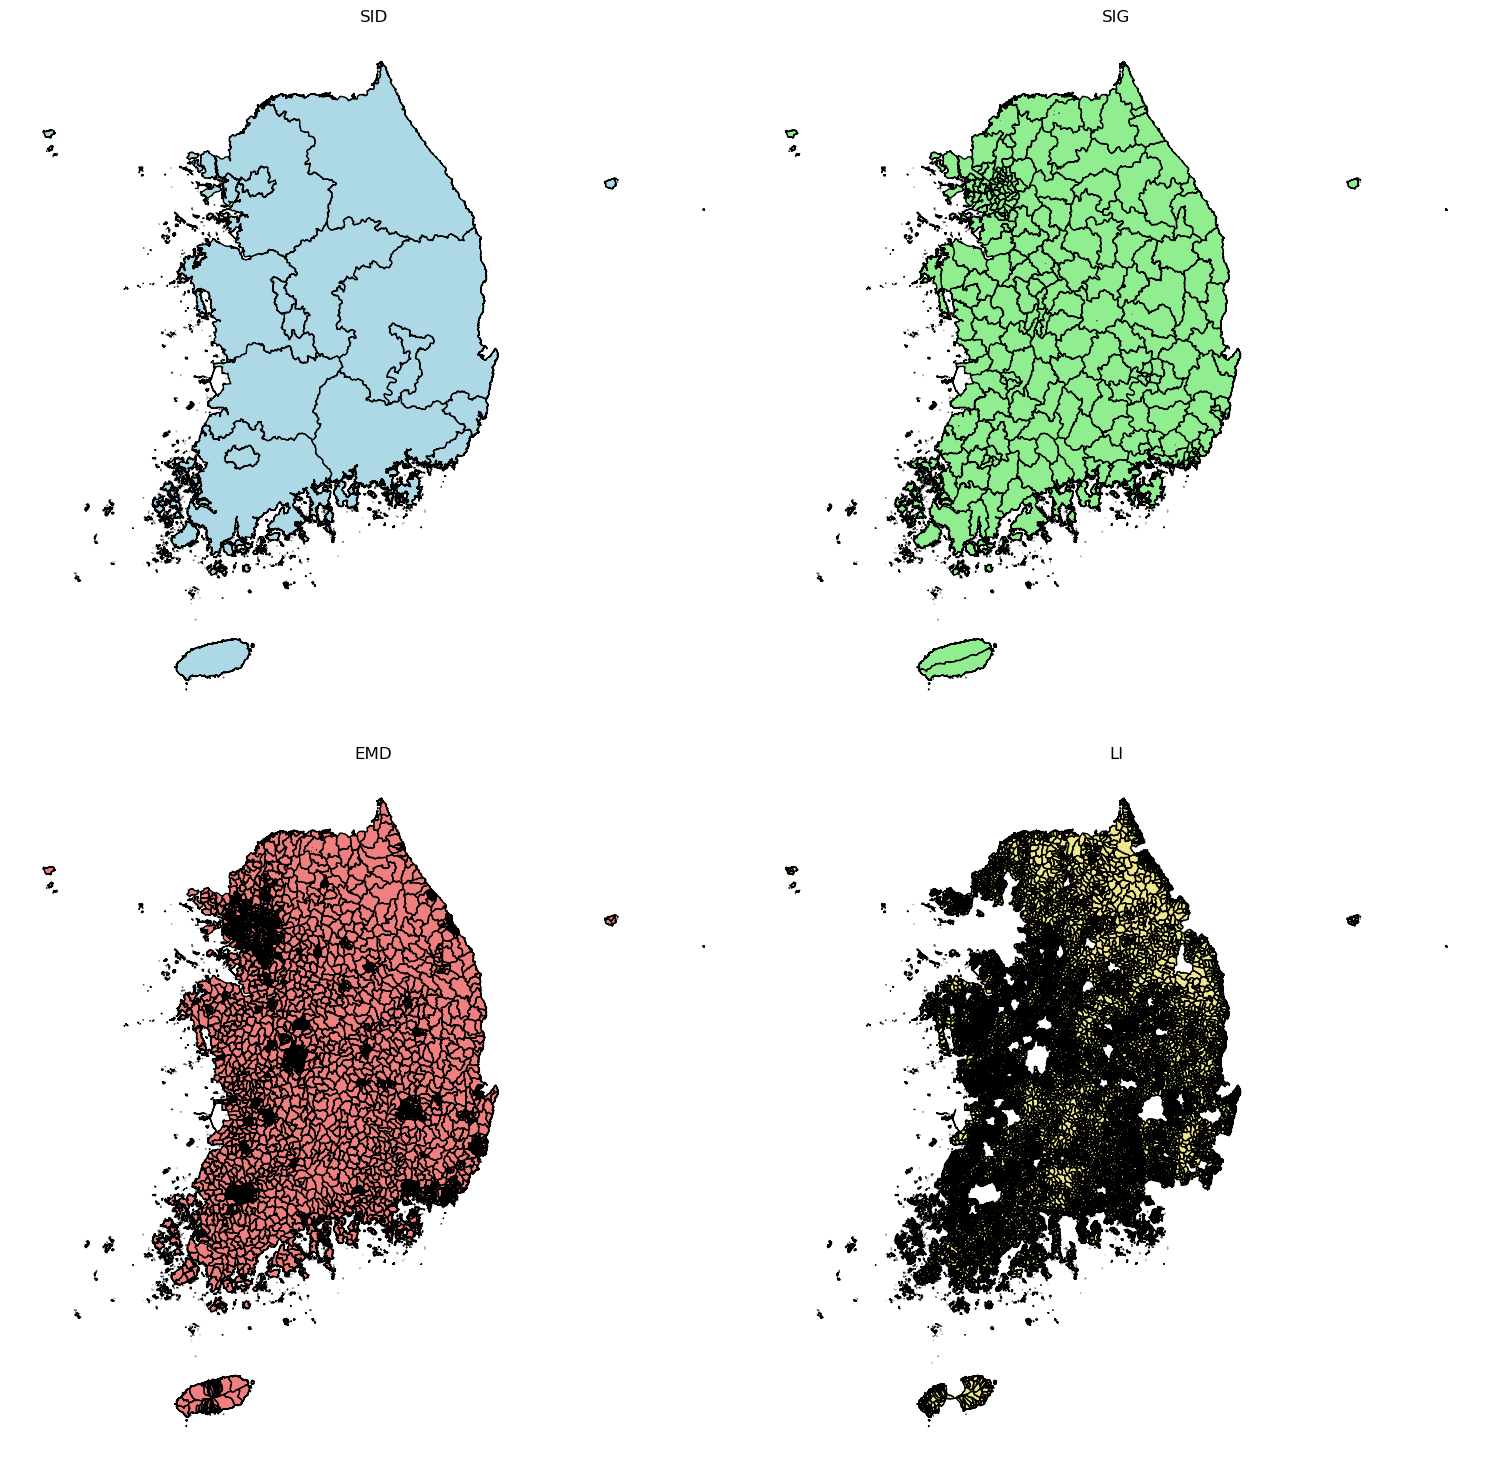

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

sid.plot(ax=axes[0, 0], edgecolor="black", facecolor="lightblue")
axes[0, 0].set_title("SID")

sig.plot(ax=axes[0, 1], edgecolor="black", facecolor="lightgreen")
axes[0, 1].set_title("SIG")

emd.plot(ax=axes[1, 0], edgecolor="black", facecolor="lightcoral")
axes[1, 0].set_title("EMD")

li.plot(ax=axes[1, 1], edgecolor="black", facecolor="khaki")
axes[1, 1].set_title("LI")

for ax in axes.flat:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### 산림청 산불상황관제시스템 산불통계데이터 EDA

In [25]:
import pandas as pd
fire = pd.read_csv("../data/raw/산불/산림청_산불상황관제시스템_산불통계데이터_20241016.csv", encoding="cp949")

In [26]:
fire.head()

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계
0,2024,9,29,15:41,일,2024,9,30,16:30,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31
1,2024,9,10,15:55,화,2024,9,10,18:00,경남,경남,밀양,NaN,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10
2,2024,9,10,14:35,화,2024,9,10,17:52,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03
3,2024,9,10,14:24,화,2024,9,10,22:00,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00
4,2024,9,5,13:51,목,2024,9,5,16:10,경북,경북,안동,녹전,매정,NaN,기타(직접입력),농산폐기물소각,0.05


In [27]:
fire.info

<bound method DataFrame.info of       발생일시_년  발생일시_월  발생일시_일 발생일시_시간 발생일시_요일  진화종료시간_년  진화종료시간_월  진화종료시간_일  \
0       2024       9      29   15:41       일      2024         9        30   
1       2024       9      10   15:55       화      2024         9        10   
2       2024       9      10   14:35       화      2024         9        10   
3       2024       9      10   14:24       화      2024         9        10   
4       2024       9       5   13:51       목      2024         9         5   
...      ...     ...     ...     ...     ...       ...       ...       ...   
1565    2022       1       3   12:36       월      2022         1         3   
1566    2022       1       3   12:02       월      2022         1         3   
1567    2022       1       2   14:29       일      2022         1         2   
1568    2022       1       2   08:18       일      2022         1         2   
1569    2022       1       1   00:24       토      2022         1         1   

     진화종료시간_시간 발생장소_관서 발생장소_시도 

In [30]:
fire.describe(include=[float, int])

,발생일시_년,발생일시_월,발생일시_일,진화종료시간_년,진화종료시간_월,진화종료시간_일,피해면적_합계
count,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000,1570.000000
mean,2022.661783,4.177070,14.826752,2022.789172,4.183439,14.780892,19.031828
std,0.714686,2.808615,8.976667,5.106340,2.808660,8.931030,428.418616
min,2022.000000,1.000000,1.000000,2022.000000,1.000000,1.000000,0.010000
25%,2022.000000,2.000000,7.000000,2022.000000,2.000000,7.000000,0.040000
50%,2023.000000,3.000000,14.000000,2023.000000,3.000000,14.000000,0.130000
75%,2023.000000,5.000000,23.000000,2023.000000,5.000000,22.000000,0.500000
max,2024.000000,12.000000,31.000000,2223.000000,12.000000,31.000000,16301.980000


In [31]:
fire.describe(include=[object])

,발생일시_시간,발생일시_요일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타
count,1570,1570,1570,1570,1570,1557,1325,1569,1347,1570,1570
unique,693,7,491,24,18,203,702,1187,4,10,366
top,14:50,일,18:00,경기,경기,양평,북,지산,기,기타(직접입력),입산자실화추정
freq,11,295,60,306,326,33,14,9,600,1143,211


In [51]:
fire["피해면적_합계"].describe()

count     1570.000000
mean        19.031828
std        428.418616
min          0.010000
25%          0.040000
50%          0.130000
75%          0.500000
max      16301.980000
Name: 피해면적_합계, dtype: float64

In [ ]:
fire.isnull().sum()

발생일시_년         0
발생일시_월         0
발생일시_일         0
발생일시_시간        0
발생일시_요일        0
진화종료시간_년       0
진화종료시간_월       0
진화종료시간_일       0
진화종료시간_시간      0
발생장소_관서        0
발생장소_시도        0
발생장소_시군구      13
발생장소_읍면      245
발생장소_동리        1
발생원인_구분      223
발생원인_세부원인      0
발생원인_기타        0
피해면적_합계        0
dtype: int64

In [34]:
# 결측치 비율
(fire.isnull().sum() / len(fire)).sort_values(ascending=False)

발생장소_읍면      0.156051
발생원인_구분      0.142038
발생장소_시군구     0.008280
발생장소_동리      0.000637
발생일시_년       0.000000
발생일시_월       0.000000
발생원인_기타      0.000000
발생원인_세부원인    0.000000
발생장소_시도      0.000000
발생장소_관서      0.000000
진화종료시간_시간    0.000000
진화종료시간_일     0.000000
진화종료시간_월     0.000000
진화종료시간_년     0.000000
발생일시_요일      0.000000
발생일시_시간      0.000000
발생일시_일       0.000000
피해면적_합계      0.000000
dtype: float64

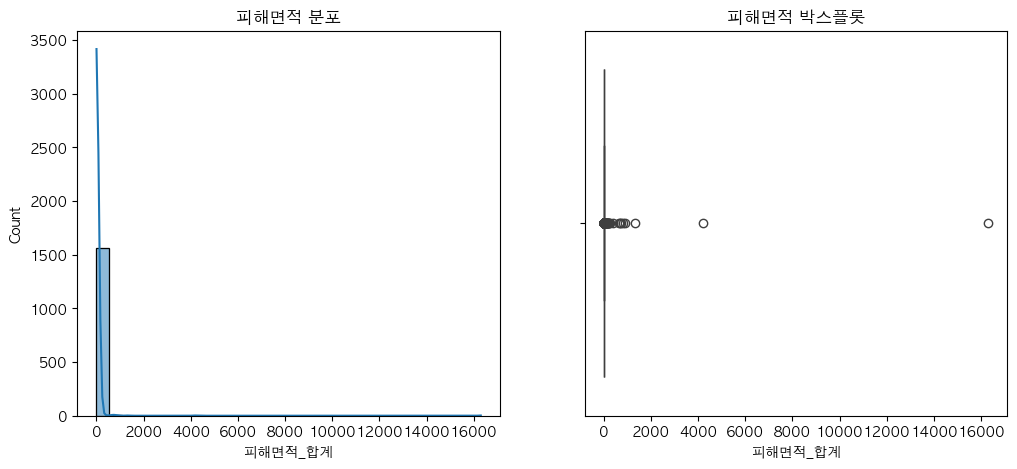

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(fire["피해면적_합계"], bins=30, kde=True)
plt.title("피해면적 분포")

plt.subplot(1, 2, 2)
sns.boxplot(x=fire["피해면적_합계"])
plt.title("피해면적 박스플롯")
plt.show()

In [ ]:
# 피해면적이 매우 큰 산불 데이터
fire[fire["피해면적_합계"] >= 4000]

# 두 데이터 모두 실제 발생했던 산불의 데이터인 것을 확인할 수 있었음

,발생일시_년,발생일시_월,발생일시_일,발생일시_시간,발생일시_요일,진화종료시간_년,진화종료시간_월,진화종료시간_일,진화종료시간_시간,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계
1318,2022,3,5,01:08,토,2022,3,11,13:00,강원,강원,강릉,옥계,남양,기,방화,방화,4190.38
1326,2022,3,4,11:17,금,2022,3,13,18:00,경북,경북,울진,북,두천,기,기타(직접입력),도로변발화추정,16301.98


In [47]:
fire[fire["피해면적_합계"] > 200].shape[0]

12

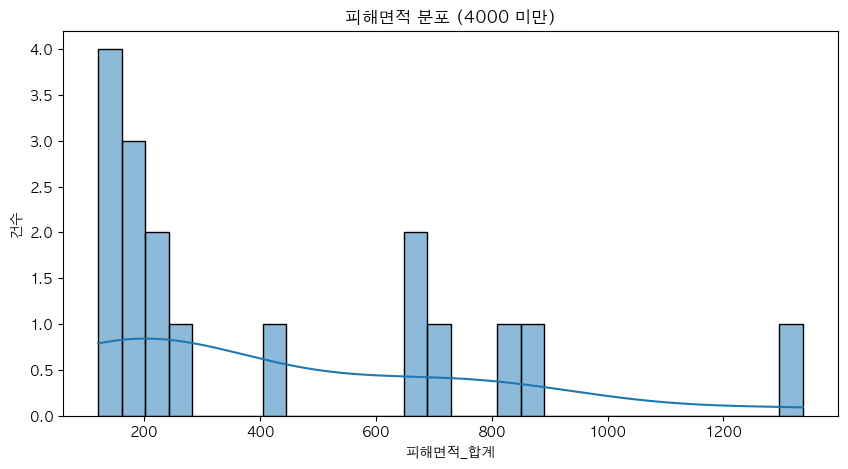

In [56]:
# 200 미만 필터링
filtered = fire[(fire["피해면적_합계"] >= 100) & (fire["피해면적_합계"] < 4000)]

# 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(filtered["피해면적_합계"], bins=30, kde=True)
plt.title("피해면적 분포 (4000 미만)")
plt.xlabel("피해면적_합계")
plt.ylabel("건수")
plt.show()

In [57]:
print(len(filtered))

17


### 산불 데이터 (https://www.bigdata-forest.kr) EDA

In [58]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# 파일 경로
fire_path = "../data/raw/산불/FRT000102_42/TB_FFAS_FF_OCCRR_42.shp"
fire = gpd.read_file(fire_path, encoding="euc-kr")

In [63]:
fire.head()

,OCCRR_DTM,OCUR_DYWK,EXTING_DTM,RQRMN_TM,ARA_NM,CTPRV_NM,SGNG_NM,EMNDN_NM,OCCCRR_RI,ARA_LTNMB,CUSE_NM,DMG_AREA,DMG_MONEY,TM_X,TM_Y,geometry
0,201303231438,토,201303231540,0102,강원,강원,원주시,지정면,안창리,산19-1,성묘객실화,None,None,1025480.61880895,1928345.38623057,POINT (1025480.619 1928345.386)
1,201303271437,수,201303271650,0213,강원,강원,춘천시,남산,강촌리,산41-3,농산폐기물소각,None,None,1013903.55033462,1979356.77605993,POINT (1013903.55 1979356.776)
2,201303280220,목,201303280245,0025,강원,강원,강릉시,교동,None,산196-2,방화 추정,None,None,1122238.56381179,1974405.35581113,POINT (1122238.564 1974405.356)
3,201301121640,토,201301121850,0210,강원,강원,양양군,강현면,용호리,산88,쓰레기소각,None,None,1097621.27167159,2014890.05439774,POINT (1097621.272 2014890.054)
4,201303041227,월,201303041400,0133,강원,강원,삼척시,근덕면,동막리,산587-2,쓰레기소각,None,None,1153848.70808644,1928576.65235905,POINT (1153848.708 1928576.652)


In [64]:
fire["DMG_AREA"] = pd.to_numeric(fire["DMG_AREA"], errors="coerce")

In [65]:
fire.head()

,OCCRR_DTM,OCUR_DYWK,EXTING_DTM,RQRMN_TM,ARA_NM,CTPRV_NM,SGNG_NM,EMNDN_NM,OCCCRR_RI,ARA_LTNMB,CUSE_NM,DMG_AREA,DMG_MONEY,TM_X,TM_Y,geometry
0,201303231438,토,201303231540,0102,강원,강원,원주시,지정면,안창리,산19-1,성묘객실화,NaN,None,1025480.61880895,1928345.38623057,POINT (1025480.619 1928345.386)
1,201303271437,수,201303271650,0213,강원,강원,춘천시,남산,강촌리,산41-3,농산폐기물소각,NaN,None,1013903.55033462,1979356.77605993,POINT (1013903.55 1979356.776)
2,201303280220,목,201303280245,0025,강원,강원,강릉시,교동,None,산196-2,방화 추정,NaN,None,1122238.56381179,1974405.35581113,POINT (1122238.564 1974405.356)
3,201301121640,토,201301121850,0210,강원,강원,양양군,강현면,용호리,산88,쓰레기소각,NaN,None,1097621.27167159,2014890.05439774,POINT (1097621.272 2014890.054)
4,201303041227,월,201303041400,0133,강원,강원,삼척시,근덕면,동막리,산587-2,쓰레기소각,NaN,None,1153848.70808644,1928576.65235905,POINT (1153848.708 1928576.652)


In [79]:
usable_data = fire[(fire["DMG_AREA"] >= 0.1) & (fire["DMG_AREA"] < 100)]

In [80]:
print("피해면적 요약 통계:")
print(usable_data["DMG_AREA"].describe())

print("\n산불 발생 원인 분포:")
print(usable_data["CUSE_NM"].value_counts().head())

print("\n시도별 산불 발생 건수:")
print(usable_data["CTPRV_NM"].value_counts())

피해면적 요약 통계:
count    958.000000
mean       2.439019
std        7.709245
min        0.100000
25%        0.200000
50%        0.500000
75%        1.500000
max       99.500000
Name: DMG_AREA, dtype: float64

산불 발생 원인 분포:
CUSE_NM
입산자실화추정    244
입산자실화      150
쓰레기소각       56
논밭두렁소각      45
농산폐기물소각     38
Name: count, dtype: int64

시도별 산불 발생 건수:
CTPRV_NM
강원    957
전북      1
Name: count, dtype: int64


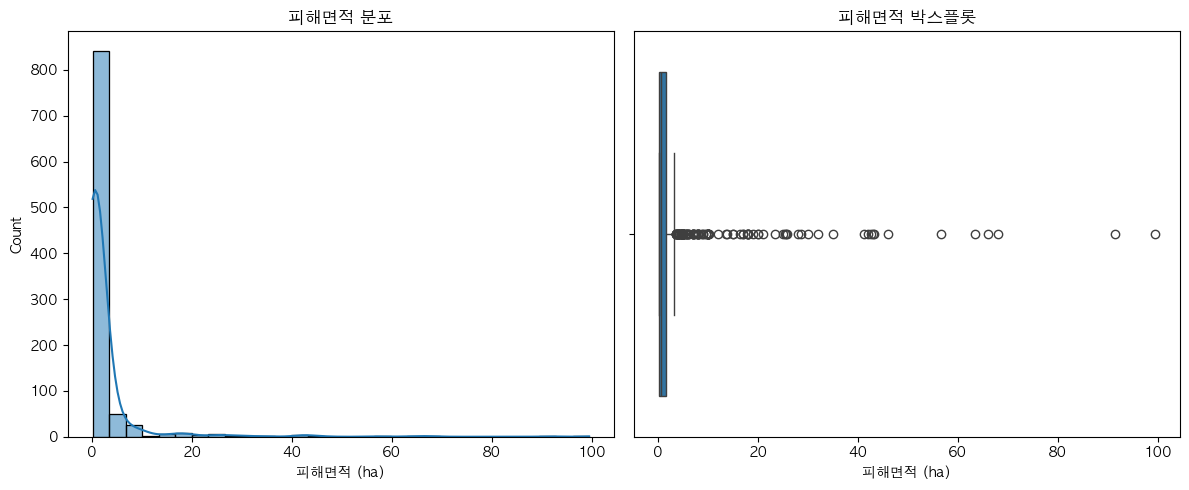

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(usable_data["DMG_AREA"], bins=30, kde=True)
plt.title("피해면적 분포")
plt.xlabel("피해면적 (ha)")

plt.subplot(1, 2, 2)
sns.boxplot(x=usable_data["DMG_AREA"])
plt.title("피해면적 박스플롯")
plt.xlabel("피해면적 (ha)")

plt.tight_layout()
plt.show()